In [1]:
# SimpleWPGen_Strip
# Ren Cooper, LBNL
# Gamma-Ray Tracking School, ORNL, October 2018
#
# very simple Weighting Potential solver for a single strip of a HPGe detector via SOR method
#  - Disclaimer: for demonstration/example purposes only!
#
# also includes a very crude example of signal generation


In [2]:
%matplotlib inline
%reset -f

In [3]:
import numpy as np
from matplotlib import pyplot as plt

In [21]:
# set some detector parameters
strip_width_mm = 2.8
strip_gap_mm = 0.2
detector_thickness_mm = 16.0
pixel_size_mm = 0.1

# set detector width to n*pitch where n is an odd number
detector_width_mm = (9*strip_width_mm+strip_gap_mm)

In [22]:
# build some grids
x_range = np.arange(-detector_width_mm/2 + pixel_size_mm, detector_width_mm/2 + pixel_size_mm, pixel_size_mm)
y_range = np.arange(-pixel_size_mm, detector_thickness_mm + pixel_size_mm, pixel_size_mm)

# initialize grid for solving for V
N_xelements = np.shape(x_range)[0]
N_yelements = np.shape(y_range)[0]
V = np.zeros((N_xelements, N_yelements), dtype=float)
W = np.zeros((N_xelements, N_yelements), dtype=float)
E = np.zeros((N_xelements, N_yelements), dtype=float)

In [23]:
# build a little map of geometry for later, designating pixels based on their nature
# Ge = 0 strip = 1 rest of strip surface = 2, back contact = 3, gap = 4
geom_map = np.zeros((N_xelements, N_yelements), dtype=int)

# continous contact
geom_map[:,0] = 3

# strip surface
geom_map[:,-1] = 2

ix = np.where((x_range>=(-strip_width_mm/2 - strip_gap_mm - strip_width_mm)) & (x_range<=(- strip_width_mm/2 - strip_gap_mm)))
geom_map[ix,-1] = 2

ix = np.where((x_range>=(strip_width_mm/2 + strip_gap_mm)) & (x_range<=(strip_width_mm/2 + strip_gap_mm + strip_width_mm)))
geom_map[ix,-1] = 2

# strip 
ix = np.where((x_range>=-strip_width_mm/2) & (x_range<=strip_width_mm/2))
geom_map[ix,-1] = 1

# gap
ix = np.where((x_range>strip_width_mm/2) & (x_range<=(strip_width_mm/2 + strip_gap_mm)))
geom_map[ix,-1] = 4
ix = np.where((x_range<-strip_width_mm/2) & (x_range>=-(strip_width_mm/2 + strip_gap_mm)))
geom_map[ix,-1] = 4

In [24]:
# set boundary conditions 

# non-strip contacts
[ix,iy] = np.where(geom_map == 2)
W[ix,iy] = 0
V[ix,iy] = 0

# back face
[ix,iy] = np.where(geom_map == 3)
W[ix,iy] = 0
V[ix,iy] = 1000

# strip
[ix,iy] = np.where(geom_map == 1)
W[ix,iy] = 1
V[ix,iy] = 0

In [25]:
# do the relaxation
# set maximum number of iterations
max_iters = 2000

# "over-relaxation" factor to speed up convergence
t = np.cos(3.14/N_xelements) + np.cos(3.14/N_yelements)
w = (8 - np.sqrt(64 - 16*t*t)) / (t*t)

# initialise arrays which will store the residuals
R = np.zeros((N_xelements, N_yelements), dtype=float)
resid_store = np.zeros(max_iters)

# perform relaxation...
resid = 1e6
iterr = 1
min_resid = 0.01

while (iterr < max_iters and resid > min_resid):    
    
    # loop over detector grid points
    for y in range(1, N_yelements-1):
        for x in range(0, N_xelements-1):
                        
            # skip pixels with boundary conditions
            if ((geom_map[x,y] == 1) or (geom_map[x,y] == 2) or (geom_map[x,y] == 3)):
                continue
                
            # should deal with some boundary conditions...
                                   
            V_local_sum = (V[x+1,y] + V[x,y+1] + V[x-1,y] + V[x,y-1])
            
            # update the solution
            R[x,y] = 0.25*V_local_sum - V[x,y]
            V[x,y] = V[x,y] + w*R[x,y]
            
    # calculate the residual and store as a function of iteration number
    resid = abs(np.sum(R))
    resid_store[iterr] = resid
    
    # update iteration counter
    iterr+=1

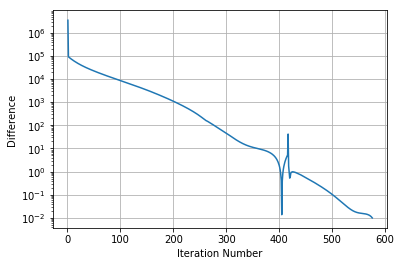

Final Difference:
0.00995099107623


In [26]:
# visualise the weighting potential
# plot difference vs. iteration number
resid_store = resid_store[1:iterr]
plt.plot(np.arange(1,iterr), resid_store)
plt.grid("on")
plt.xlabel("Iteration Number")
plt.ylabel("Difference")
plt.yscale("log")
plt.show()

# also print the final difference 
print("Final Difference:")
print(resid_store[-1])

In [27]:
# do the relaxation
# set maximum number of iterations
max_iters = 2000

# "over-relaxation" factor to speed up convergence
t = np.cos(3.14/N_xelements) + np.cos(3.14/N_yelements)
w = (8 - np.sqrt(64 - 16*t*t)) / (t*t)

# initialise arrays which will store the residuals
R = np.zeros((N_xelements, N_yelements), dtype=float)
resid_store = np.zeros(max_iters)

# perform relaxation...
resid = 1e6
iterr = 1
min_resid = 0.01

while (iterr < max_iters and resid > min_resid):    
    
    # loop over detector grid points
    for y in range(1, N_yelements-1):
        for x in range(0, N_xelements-1):
                        
            # skip pixels with boundary conditions
            if ((geom_map[x,y] == 1) or (geom_map[x,y] == 2) or (geom_map[x,y] == 3)):
                continue
                
            # should deal with some boundary conditions...
                                   
            W_local_sum = (W[x+1,y] + W[x,y+1] + W[x-1,y] + W[x,y-1])
            
            # update the solution
            R[x,y] = 0.25*W_local_sum - W[x,y]
            W[x,y] = W[x,y] + w*R[x,y]
            
    # calculate the residual and store as a function of iteration number
    resid = abs(np.sum(R))
    resid_store[iterr] = resid
    
    # update iteration counter
    iterr+=1

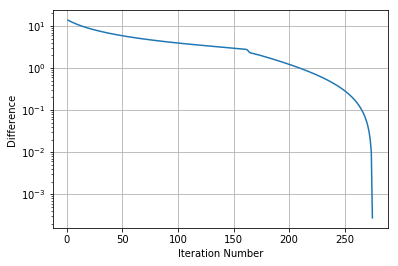

Final Difference:
0.000272582469532


In [28]:
# visualise the weighting potential
# plot difference vs. iteration number
resid_store = resid_store[1:iterr]
plt.plot(np.arange(1,iterr), resid_store)
plt.grid("on")
plt.xlabel("Iteration Number")
plt.ylabel("Difference")
plt.yscale("log")
plt.show()

# also print the final difference 
print("Final Difference:")
print(resid_store[-1])

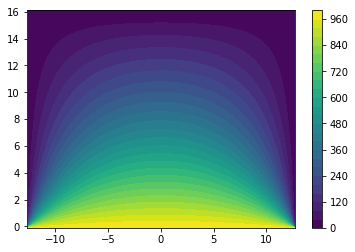

In [29]:
X, Y = np.meshgrid(y_range, x_range)
plt.contourf(Y,X, V, 30)
plt.xlim(-detector_width_mm/2, detector_width_mm/2)
plt.colorbar()

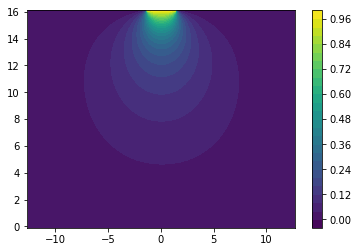

In [30]:
X, Y = np.meshgrid(y_range, x_range)
plt.contourf(Y,X, W, 30)
plt.xlim(-detector_width_mm/2, detector_width_mm/2)
plt.colorbar()

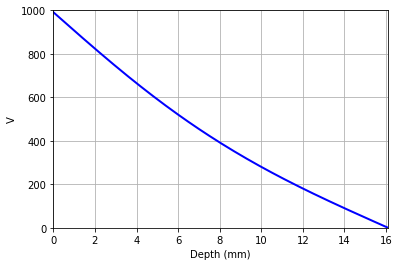

In [31]:
# take a slice through the V
x_slice = 125
Vslice = V[x_slice,:]

plt.plot(y_range, Vslice, 'b-',linewidth=2)
plt.grid("on")
plt.xlabel("Depth (mm)")
plt.ylabel("V")
plt.xlim(0, 16.1)
plt.ylim(0, 1000)
plt.show()


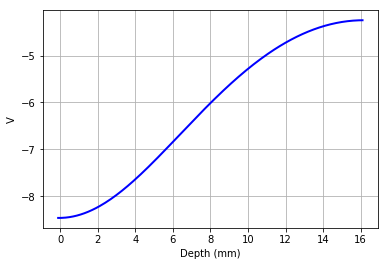

In [32]:

# take a slice through the WP

x_slice = 125
Eslice = np.diff(Vslice) #V[x_slice,:]
Eslice = np.insert(Eslice, 0, Eslice[0])
plt.plot(y_range, Eslice, 'b-',linewidth=2)
plt.grid("on")
plt.xlabel("Depth (mm)")
plt.ylabel("V")
#plt.xlim(0, 16.1)
#plt.ylim(0, 1000)
plt.show()


In [33]:
print(Eslice[0])

-8.45764459636


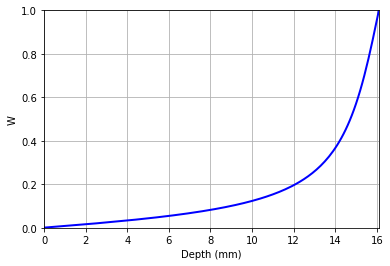

In [34]:
# take a slice through the WP
x_slice = 125
Wslice = W[x_slice,:]

plt.plot(y_range, Wslice, 'b-',linewidth=2)
plt.grid("on")
plt.xlabel("Depth (mm)")
plt.ylabel("W")
plt.xlim(0, 16.1)
plt.ylim(0, 1)
plt.show()


80


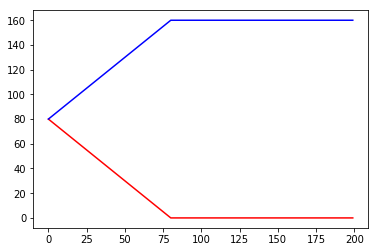

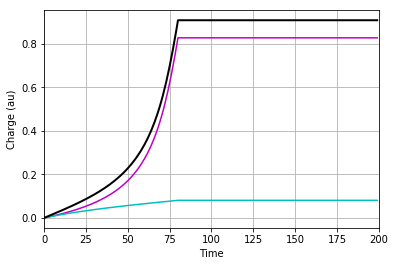

In [107]:
mue = (3.6 * 10 ** 4)/(10**9)
muh = (4.2 * 10 ** 4)/(10**9) 
eps_0 = 8.85 * 10 ** (-14) 
eps = 16 * eps_0
rho = 10**10  # cm^-3
q = 1.6 * 10 ** (-19)
V = 1000 # V

# assume an interaction position at a given depth
depth_mm = 8

z0 = np.int(np.floor(depth_mm / pixel_size_mm))
print(z0)
maxval = 16 / pixel_size_mm

# number of time steps in signal
Nt = 200

# arrays which will store the induced charge signals
Qh = np.zeros(Nt, dtype=float)
Qe = np.zeros(Nt, dtype=float)

# starting positions for electrons and holes
zh_list = []
ze_list = []
zh_list.append(z0)
ze_list.append(z0)
# holes into wp
t = 0
x_list = []
zh = z0
ze = z0
for t in range(1, Nt):
    x = zh_list[-1]
    #print('-----')
    #print(x)
    vh = muh * Eslice[x]
    #zh = zh + vh * 1 # ns
    #print(zh)
    #print(np.floor(vh / pixel_size_mm))
    #print((vh / pixel_size_mm))
    #print(np.int(zh + np.floor(vh / pixel_size_mm)))
    zh = np.int(zh + np.floor(vh / pixel_size_mm))
    if zh < 0:
        zh = 0
    if zh >= int(maxval):
        zh = int(maxval)
    zh_list.append(zh)
    #x_list.append(x_list[-1] + np.floor(vh))
    if (zh> maxval):
        continue
    elif (zh<=N_yelements-1):
        if x == maxval:
            dw = Wslice[zh_list[t]] - 1
        else:
            dw = Wslice[zh_list[t]] - Wslice[zh_list[t-1]]
        Qh[t] = 1.0*dw    
    elif (zh>N_yelements-1):
        continue

# electrons out of wp
t = 0
for t in range(1, Nt):
    x = ze_list[-1]
    #print(x)
    
    ve = mue * Eslice[x]
    ze = np.int(ze - np.floor(ve / pixel_size_mm))
    if ze < 0:
        ze = 0
    if ze>= int(maxval):
        ze = int(maxval)
    ze_list.append(ze)
    if (ze> maxval):
        continue
    elif (ze>=0):
        if x == 0:
            dw = Wslice[ze_list[t]] - 0
        else:
            dw = Wslice[ze_list[t]] - Wslice[ze_list[t-1]]
        #dw = Wslice[ze_list[t]] - Wslice[ze_list[t-1]]
        Qe[t] = -1.0*dw
    elif (ze<0):
        continue

# take cumulative sums
Qsignal_h = np.cumsum(Qh)
Qsignal_e = np.cumsum(Qe)
Qsignal = np.cumsum(Qe + Qh)

plt.plot(zh_list,'r-')
plt.plot(ze_list,'b-')
plt.show()

# plot
plt.plot(-1 * Qsignal_e, 'm', linewidth=1.5)
plt.plot(-1 * Qsignal_h, 'c', linewidth=1.5)
plt.plot(-1 * Qsignal, 'k', linewidth=2)

plt.grid("on")
#plt.ylim(0,1)
plt.xlim(0, Nt)
#plt.tick_params(labelbottom="off")
plt.xlabel("Time")
plt.ylabel("Charge (au)")
#plt.legend()
plt.show()

0


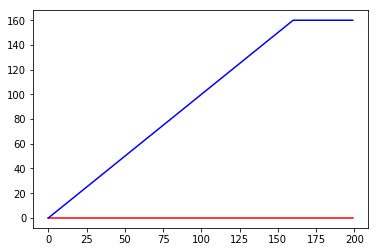

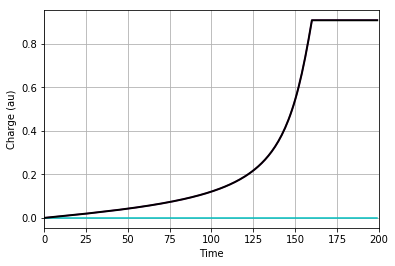

10


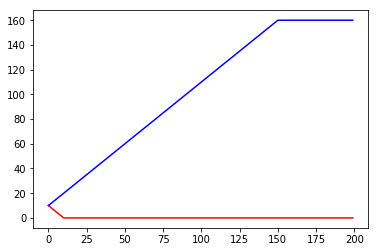

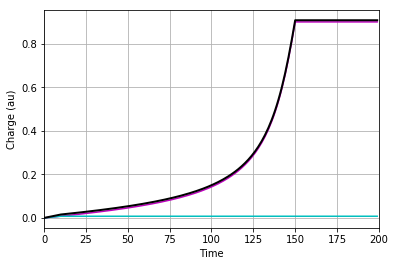

20


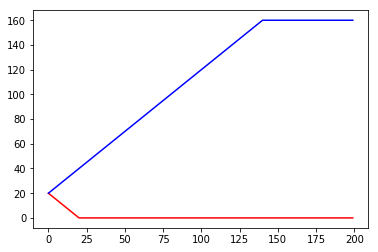

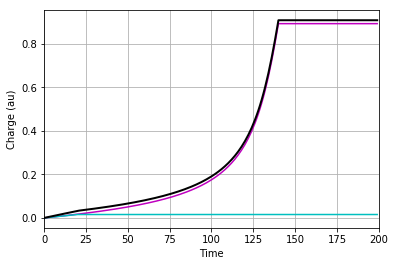

30


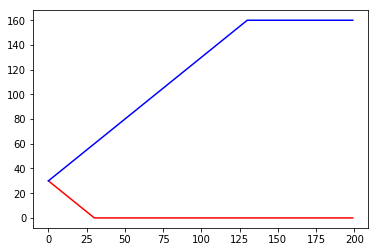

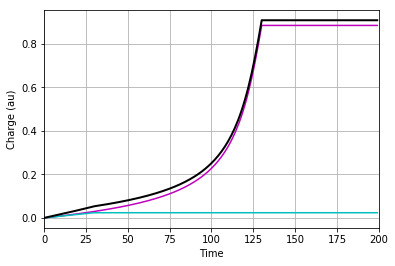

40


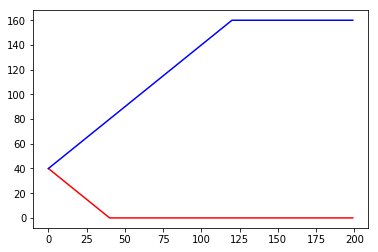

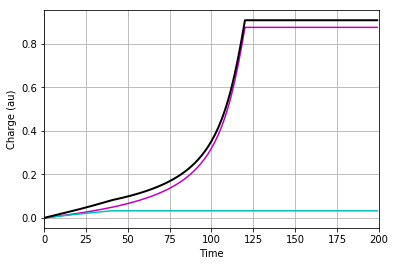

50


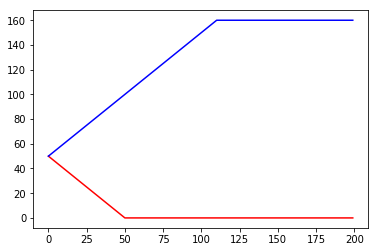

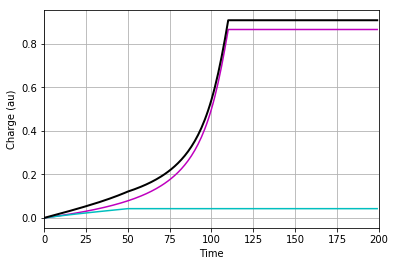

60


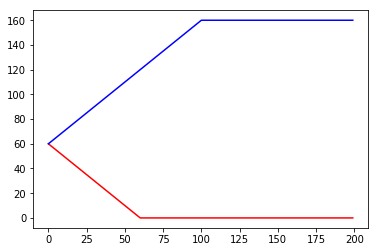

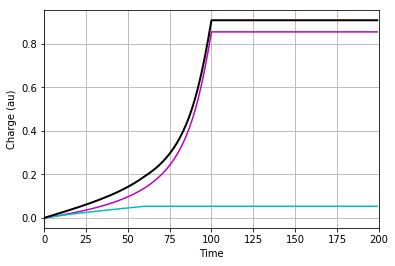

70


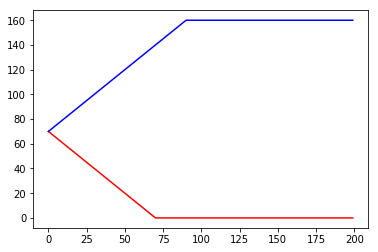

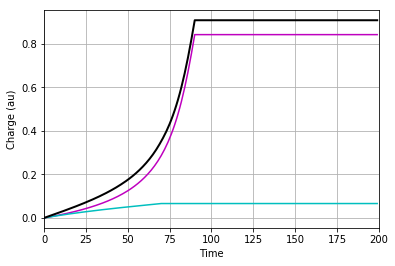

80


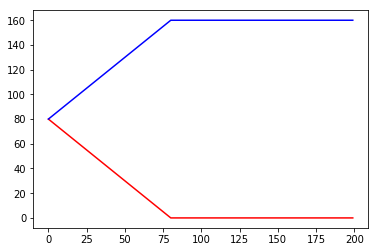

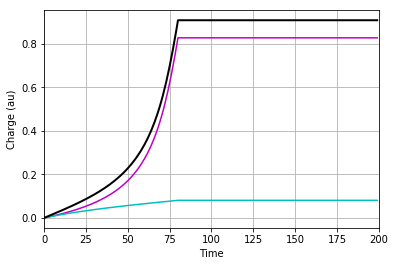

90


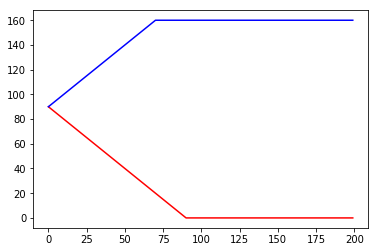

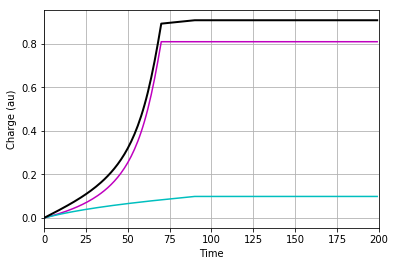

100


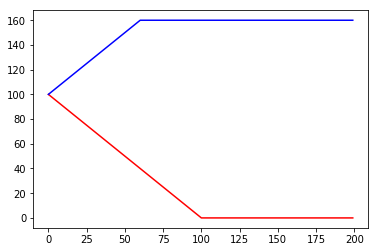

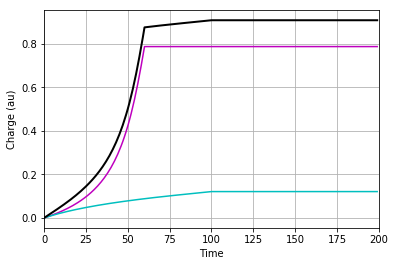

110


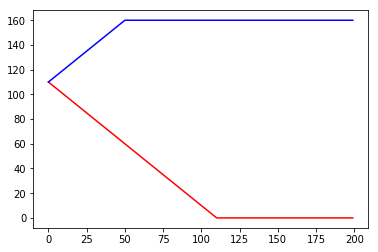

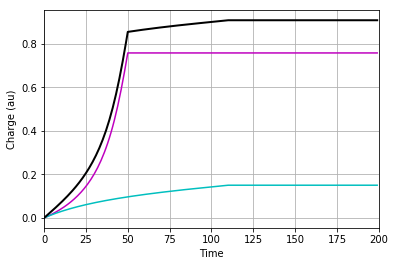

120


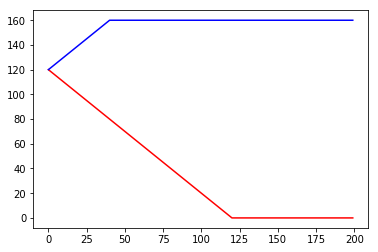

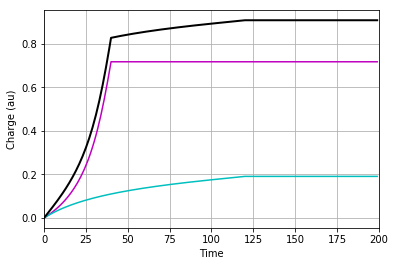

130


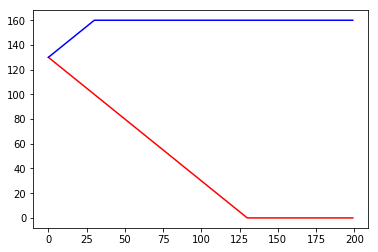

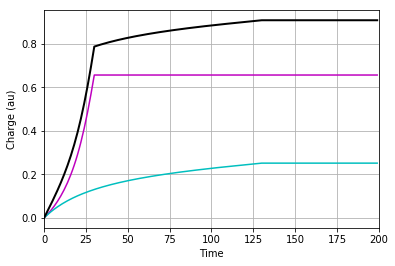

140


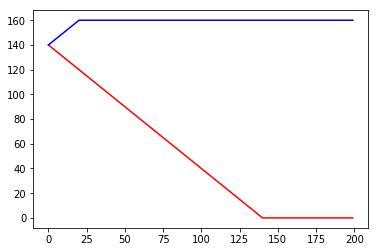

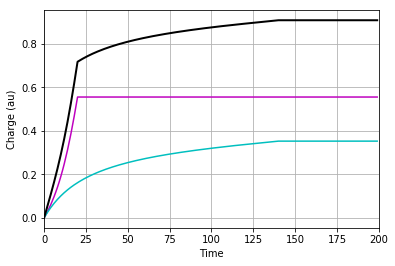

150


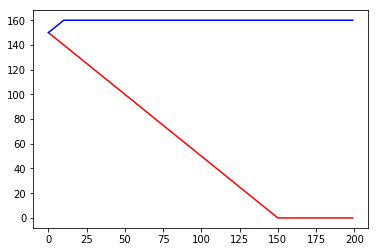

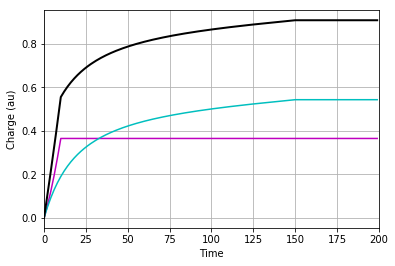

160


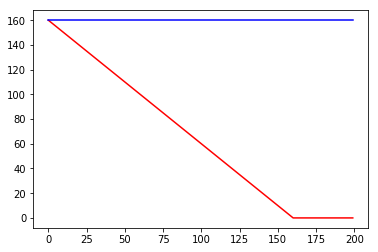

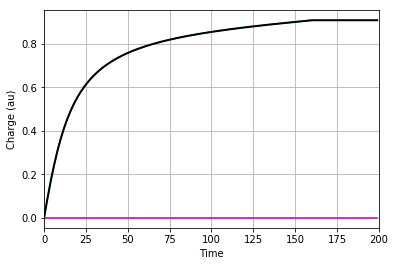

In [119]:
mue = (3.6 * 10 ** 4)/(10**9)
muh = (4.2 * 10 ** 4)/(10**9) 
eps_0 = 8.85 * 10 ** (-14) 
eps= 16 * eps_0
rho = 10**10  # cm^-3
q = 1.6 * 10 ** (-19)
V = 1000 # V

Qsignal_h_arr = np.zeros((17,200), dtype=float)
Qsignal_e_arr = np.zeros((17,200), dtype=float)
Qsignal_arr = np.zeros((17,200), dtype=float)

# assume an interaction position at a given depth
for i in range(0,17,1):
    depth_mm = i

    z0 = np.int(np.floor(depth_mm / pixel_size_mm))
    print(z0)
    maxval = 16 / pixel_size_mm

    # number of time steps in signal
    Nt = 200

    # arrays which will store the induced charge signals
    Qh = np.zeros(Nt, dtype=float)
    Qe = np.zeros(Nt, dtype=float)

    # starting positions for electrons and holes
    zh_list = []
    ze_list = []
    zh_list.append(z0)
    ze_list.append(z0)
    # holes into wp
    t = 0
    x_list = []
    zh = z0
    ze = z0
    for t in range(1, Nt):
        x = zh_list[-1]
        #print('-----')
        #print(x)
        vh = muh * Eslice[x]
        #zh = zh + vh * 1 # ns
        #print(zh)
        #print(np.floor(vh / pixel_size_mm))
        #print((vh / pixel_size_mm))
        #print(np.int(zh + np.floor(vh / pixel_size_mm)))
        zh = np.int(zh + np.floor(vh / pixel_size_mm))
        if zh < 0:
            zh = 0
        if zh >= int(maxval):
            zh = int(maxval)
        zh_list.append(zh)
        #x_list.append(x_list[-1] + np.floor(vh))
        if (zh> maxval):
            continue
        elif (zh<=N_yelements-1):
            dw = Wslice[zh_list[t]] - Wslice[zh_list[t-1]]
            Qh[t] = 1.0*dw    
        elif (zh>N_yelements-1):
            continue

    # electrons out of wp
    t = 0
    for t in range(1, Nt):
        x = ze_list[-1]
        #print(x)
        
        ve = mue * Eslice[x]
        ze = np.int(ze - np.floor(ve / pixel_size_mm))
        if ze < 0:
            ze = 0
        if ze>= int(maxval):
            ze = int(maxval)
        ze_list.append(ze)
        if (ze> maxval):
            continue
        elif (ze>=0):
            dw = Wslice[ze_list[t]] - Wslice[ze_list[t-1]]
            Qe[t] = -1.0*dw
        elif (ze<0):
            continue

    # take cumulative sums
    Qh = -1*Qh
    Qe = -1*Qe
    Qsignal_h = np.cumsum(Qh)
    Qsignal_e = np.cumsum(Qe)
    Qsignal = np.cumsum(Qe + Qh)
    
    Qsignal_h_arr[i] = Qsignal_h
    Qsignal_e_arr[i] = Qsignal_e
    Qsignal_arr[i] = Qsignal

    plt.plot(zh_list,'r-')
    plt.plot(ze_list,'b-')
    plt.show()

    # plot
    plt.plot(Qsignal_e, 'm', linewidth=1.5)
    plt.plot(Qsignal_h, 'c', linewidth=1.5)
    plt.plot(Qsignal, 'k', linewidth=2)

    plt.grid("on")
    #plt.ylim(0,1)
    plt.xlim(0, Nt)
    #plt.tick_params(labelbottom="off")
    plt.xlabel("Time")
    plt.ylabel("Charge (au)")
    #plt.legend()
    plt.show()
    
    

In [121]:
ristime_diffs = []

for i in range(0, 17):
    t50_e = 0
    t50_h = 0
    
    Qsignal = Qsignal_arr[i]
    
    high = 0
    low = 0
    
    #plt.plot(Qsignal_h)
    #plt.plot(Qsignal_e)
    #plt.show()
    
    
    for j in range(0, len(Qsignal)):
        #print(j)
        #print(Qsignal_e[j])
        #print(0.5*np.amax(Qsignal_e))
        if Qsignal[j] < 0.5*np.amax(Qsignal):
            low = j
        if Qsignal[j] > 0.5*np.amax(Qsignal):
            high = j
            break

    t50_1 = (high + low) / 2.0  # ns
    
    ristime_diffs.append(t50_1 )#- t50_2)
    

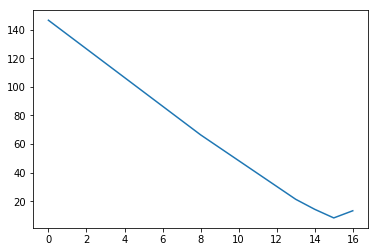

In [123]:
plt.plot(ristime_diffs,'-')
plt.show()

In [124]:
# build some grids
x_range = np.arange(-detector_width_mm/2 + pixel_size_mm, detector_width_mm/2 + pixel_size_mm, pixel_size_mm)
y_range = np.arange(-pixel_size_mm, detector_thickness_mm + pixel_size_mm, pixel_size_mm)

# initialize grid for solving for V
N_xelements = np.shape(x_range)[0]
N_yelements = np.shape(y_range)[0]
V = np.zeros((N_xelements, N_yelements), dtype=float)
W = np.zeros((N_xelements, N_yelements), dtype=float)
E = np.zeros((N_xelements, N_yelements), dtype=float)

# build a little map of geometry for later, designating pixels based on their nature
# Ge = 0 strip = 1 rest of strip surface = 2, back contact = 3, gap = 4
geom_map = np.zeros((N_xelements, N_yelements), dtype=int)

# continous contact
geom_map[:,0] = 3

# strip surface
geom_map[:,-1] = 2

ix = np.where((x_range>=(-strip_width_mm/2 - strip_gap_mm - strip_width_mm)) & (x_range<=(- strip_width_mm/2 - strip_gap_mm)))
geom_map[ix,-1] = 2

ix = np.where((x_range>=(strip_width_mm/2 + strip_gap_mm)) & (x_range<=(strip_width_mm/2 + strip_gap_mm + strip_width_mm)))
geom_map[ix,-1] = 2

# strip 
ix = np.where((x_range>=-strip_width_mm/2) & (x_range<=strip_width_mm/2))
geom_map[ix,-1] = 1

# gap
ix = np.where((x_range>strip_width_mm/2) & (x_range<=(strip_width_mm/2 + strip_gap_mm)))
geom_map[ix,-1] = 4
ix = np.where((x_range<-strip_width_mm/2) & (x_range>=-(strip_width_mm/2 + strip_gap_mm)))
geom_map[ix,-1] = 4

# set boundary conditions 

# non-strip contacts
[ix,iy] = np.where(geom_map == 2)
W[ix,iy] = 0
V[ix,iy] = 0

# back face
[ix,iy] = np.where(geom_map == 3)
W[ix,iy] = 1
V[ix,iy] = 1000

# strip
[ix,iy] = np.where(geom_map == 1)
W[ix,iy] = 0
V[ix,iy] = 0

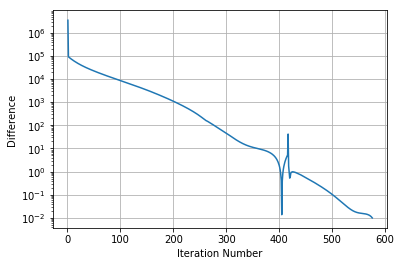

Final Difference:
0.00995099107623


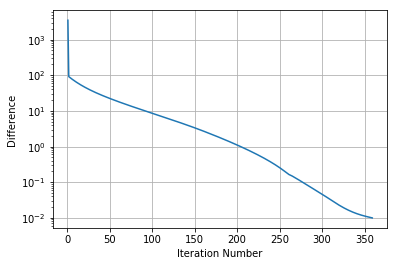

Final Difference:
0.00996579592451


In [125]:
# do the relaxation
# set maximum number of iterations
max_iters = 2000

# "over-relaxation" factor to speed up convergence
t = np.cos(3.14/N_xelements) + np.cos(3.14/N_yelements)
w = (8 - np.sqrt(64 - 16*t*t)) / (t*t)

# initialise arrays which will store the residuals
R = np.zeros((N_xelements, N_yelements), dtype=float)
resid_store = np.zeros(max_iters)

# perform relaxation...
resid = 1e6
iterr = 1
min_resid = 0.01

while (iterr < max_iters and resid > min_resid):    
    
    # loop over detector grid points
    for y in range(1, N_yelements-1):
        for x in range(0, N_xelements-1):
                        
            # skip pixels with boundary conditions
            if ((geom_map[x,y] == 1) or (geom_map[x,y] == 2) or (geom_map[x,y] == 3)):
                continue
                
            # should deal with some boundary conditions...
                                   
            V_local_sum = (V[x+1,y] + V[x,y+1] + V[x-1,y] + V[x,y-1])
            
            # update the solution
            R[x,y] = 0.25*V_local_sum - V[x,y]
            V[x,y] = V[x,y] + w*R[x,y]
            
    # calculate the residual and store as a function of iteration number
    resid = abs(np.sum(R))
    resid_store[iterr] = resid
    
    # update iteration counter
    iterr+=1
# visualise the weighting potential
# plot difference vs. iteration number
resid_store = resid_store[1:iterr]
plt.plot(np.arange(1,iterr), resid_store)
plt.grid("on")
plt.xlabel("Iteration Number")
plt.ylabel("Difference")
plt.yscale("log")
plt.show()

# also print the final difference 
print("Final Difference:")
print(resid_store[-1])

# do the relaxation
# set maximum number of iterations
max_iters = 2000

# "over-relaxation" factor to speed up convergence
t = np.cos(3.14/N_xelements) + np.cos(3.14/N_yelements)
w = (8 - np.sqrt(64 - 16*t*t)) / (t*t)

# initialise arrays which will store the residuals
R = np.zeros((N_xelements, N_yelements), dtype=float)
resid_store = np.zeros(max_iters)

# perform relaxation...
resid = 1e6
iterr = 1
min_resid = 0.01

while (iterr < max_iters and resid > min_resid):    
    
    # loop over detector grid points
    for y in range(1, N_yelements-1):
        for x in range(0, N_xelements-1):
                        
            # skip pixels with boundary conditions
            if ((geom_map[x,y] == 1) or (geom_map[x,y] == 2) or (geom_map[x,y] == 3)):
                continue
                
            # should deal with some boundary conditions...
                                   
            W_local_sum = (W[x+1,y] + W[x,y+1] + W[x-1,y] + W[x,y-1])
            
            # update the solution
            R[x,y] = 0.25*W_local_sum - W[x,y]
            W[x,y] = W[x,y] + w*R[x,y]
            
    # calculate the residual and store as a function of iteration number
    resid = abs(np.sum(R))
    resid_store[iterr] = resid
    
    # update iteration counter
    iterr+=1
    # visualise the weighting potential
# plot difference vs. iteration number
resid_store = resid_store[1:iterr]
plt.plot(np.arange(1,iterr), resid_store)
plt.grid("on")
plt.xlabel("Iteration Number")
plt.ylabel("Difference")
plt.yscale("log")
plt.show()

# also print the final difference 
print("Final Difference:")
print(resid_store[-1])



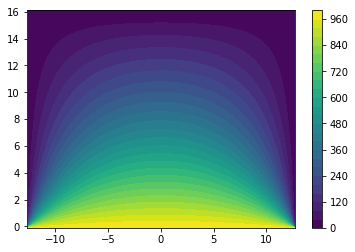

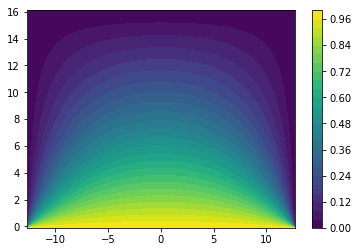

In [128]:
X, Y = np.meshgrid(y_range, x_range)
plt.contourf(Y,X, V, 30)
plt.xlim(-detector_width_mm/2, detector_width_mm/2)
plt.colorbar()
plt.show()

X, Y = np.meshgrid(y_range, x_range)
plt.contourf(Y,X, W, 30)
plt.xlim(-detector_width_mm/2, detector_width_mm/2)
plt.colorbar()
plt.show()

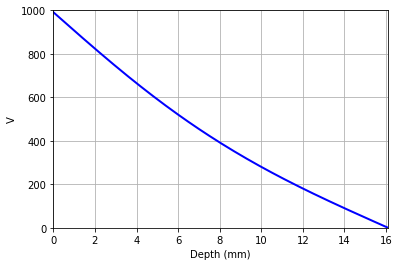

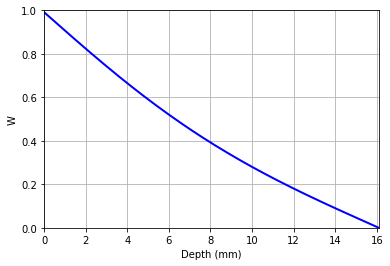

In [129]:
# take a slice through the V
x_slice = 125
Vslice = V[x_slice,:]

plt.plot(y_range, Vslice, 'b-',linewidth=2)
plt.grid("on")
plt.xlabel("Depth (mm)")
plt.ylabel("V")
plt.xlim(0, 16.1)
plt.ylim(0, 1000)
plt.show()

# take a slice through the WP
x_slice = 125
Wslice = W[x_slice,:]

plt.plot(y_range, Wslice, 'b-',linewidth=2)
plt.grid("on")
plt.xlabel("Depth (mm)")
plt.ylabel("W")
plt.xlim(0, 16.1)
plt.ylim(0, 1)
plt.show()


0


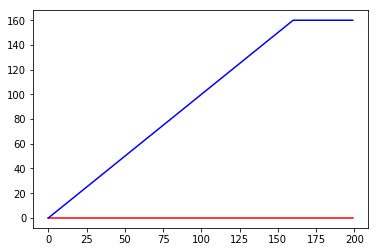

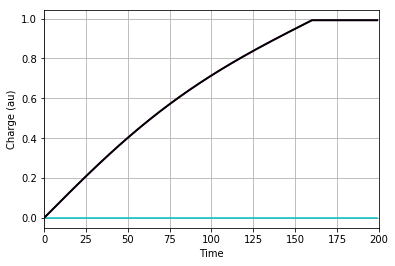

10


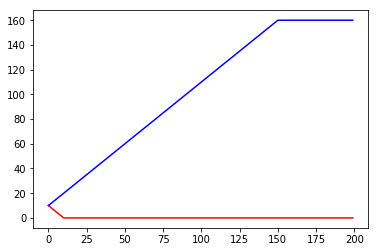

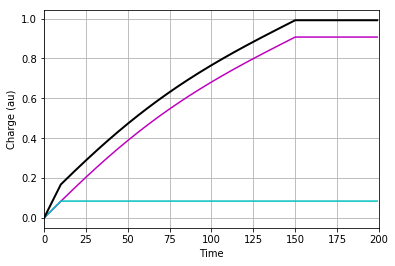

20


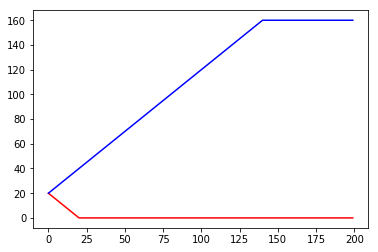

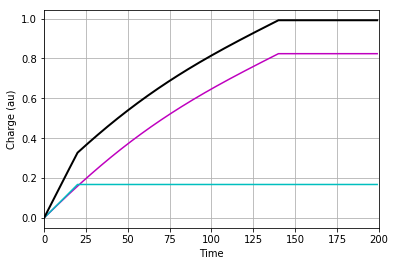

30


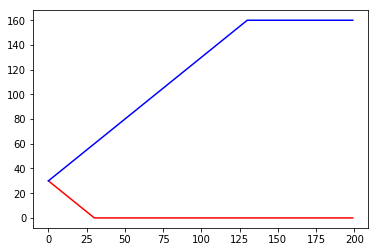

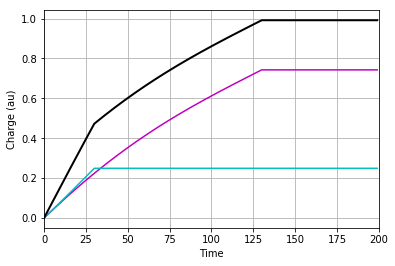

40


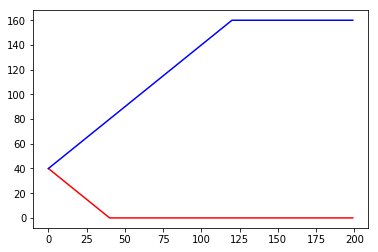

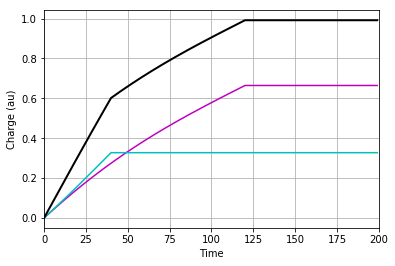

50


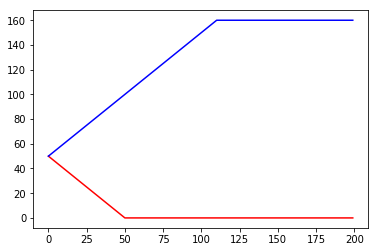

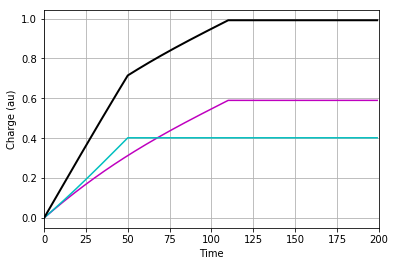

60


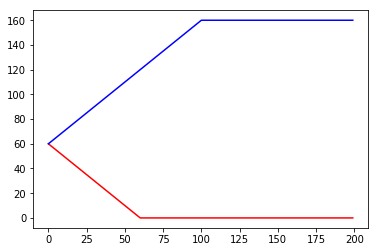

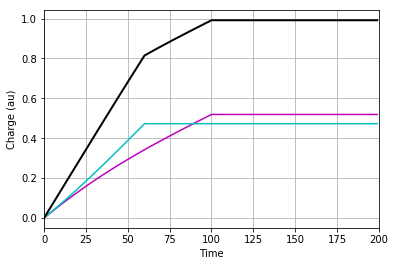

70


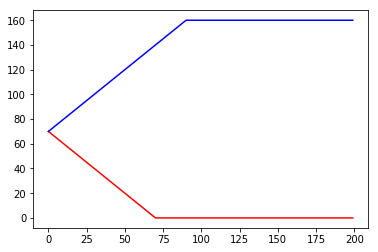

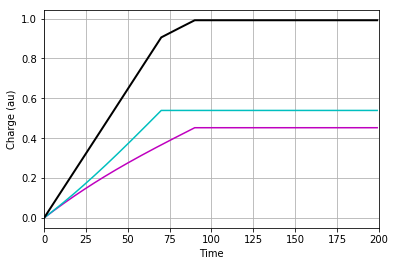

80


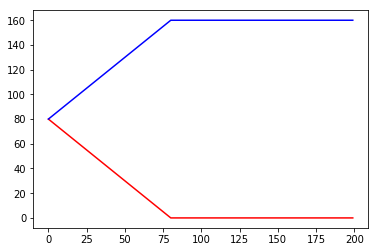

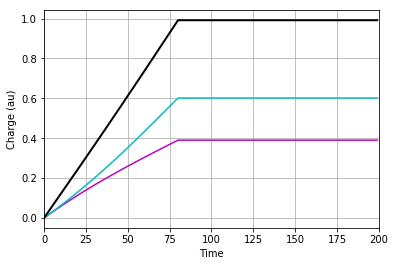

90


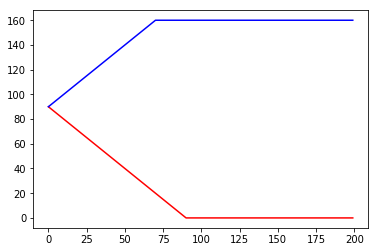

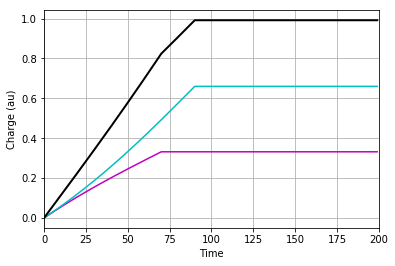

100


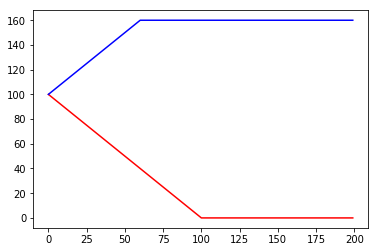

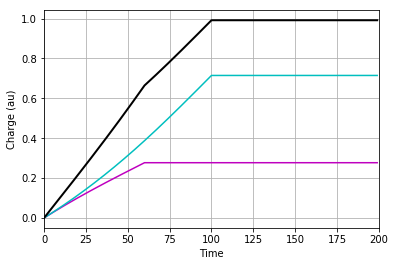

110


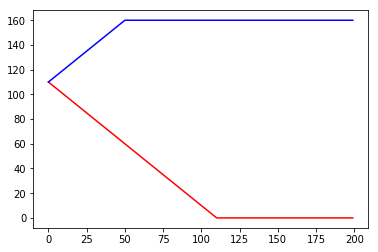

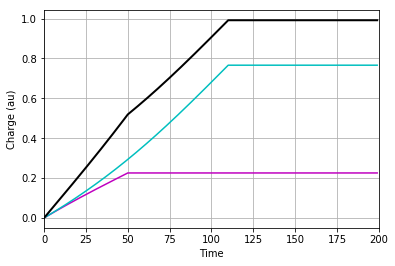

120


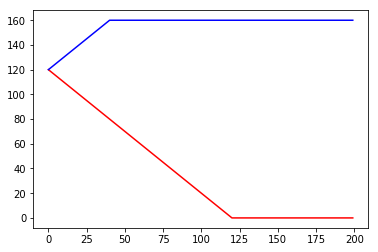

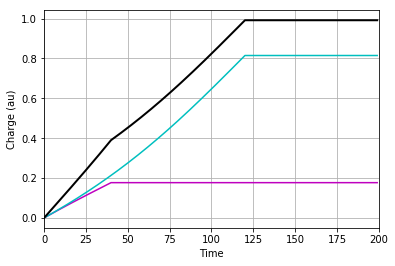

130


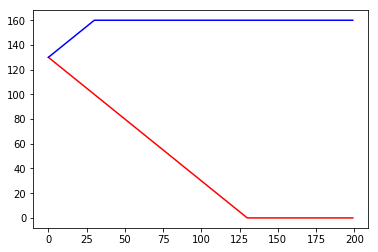

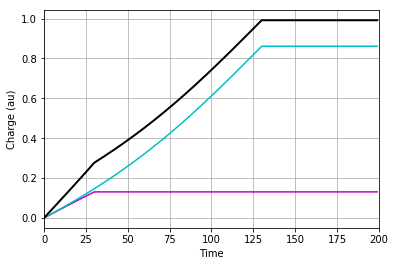

140


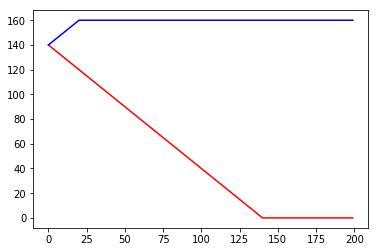

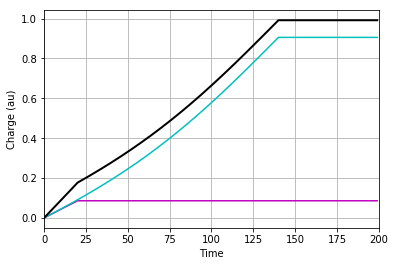

150


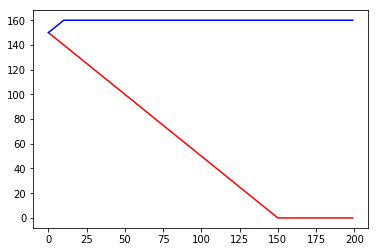

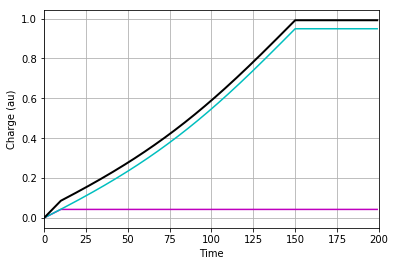

160


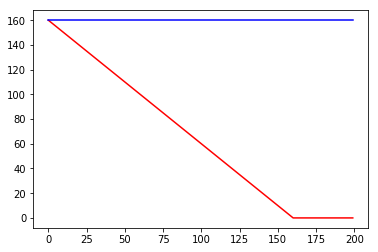

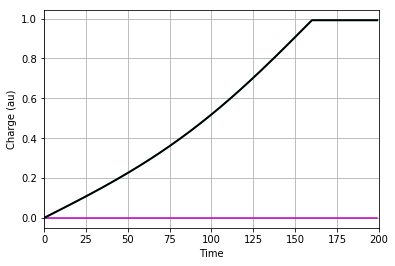

In [131]:
mue = (3.6 * 10 ** 4)/(10**9)
muh = (4.2 * 10 ** 4)/(10**9) 
eps_0 = 8.85 * 10 ** (-14) 
eps= 16 * eps_0
rho = 10**10  # cm^-3
q = 1.6 * 10 ** (-19)
V = 1000 # V

Qsignal_h_arr = np.zeros((17,200), dtype=float)
Qsignal_e_arr = np.zeros((17,200), dtype=float)
Qsignal_arr_bot = np.zeros((17,200), dtype=float)

# assume an interaction position at a given depth
for i in range(0,17,1):
    depth_mm = i

    z0 = np.int(np.floor(depth_mm / pixel_size_mm))
    print(z0)
    maxval = 16 / pixel_size_mm

    # number of time steps in signal
    Nt = 200

    # arrays which will store the induced charge signals
    Qh = np.zeros(Nt, dtype=float)
    Qe = np.zeros(Nt, dtype=float)

    # starting positions for electrons and holes
    zh_list = []
    ze_list = []
    zh_list.append(z0)
    ze_list.append(z0)
    # holes into wp
    t = 0
    x_list = []
    zh = z0
    ze = z0
    for t in range(1, Nt):
        x = zh_list[-1]
        #print('-----')
        #print(x)
        vh = muh * Eslice[x]
        #zh = zh + vh * 1 # ns
        #print(zh)
        #print(np.floor(vh / pixel_size_mm))
        #print((vh / pixel_size_mm))
        #print(np.int(zh + np.floor(vh / pixel_size_mm)))
        zh = np.int(zh + np.floor(vh / pixel_size_mm))
        if zh < 0:
            zh = 0
        if zh >= int(maxval):
            zh = int(maxval)
        zh_list.append(zh)
        #x_list.append(x_list[-1] + np.floor(vh))
        if (zh> maxval):
            continue
        elif (zh<=N_yelements-1):
            dw = Wslice[zh_list[t]] - Wslice[zh_list[t-1]]
            Qh[t] = 1.0*dw    
        elif (zh>N_yelements-1):
            continue

    # electrons out of wp
    t = 0
    for t in range(1, Nt):
        x = ze_list[-1]
        #print(x)
        
        ve = mue * Eslice[x]
        ze = np.int(ze - np.floor(ve / pixel_size_mm))
        if ze < 0:
            ze = 0
        if ze>= int(maxval):
            ze = int(maxval)
        ze_list.append(ze)
        if (ze> maxval):
            continue
        elif (ze>=0):
            dw = Wslice[ze_list[t]] - Wslice[ze_list[t-1]]
            Qe[t] = -1.0*dw
        elif (ze<0):
            continue

    # take cumulative sums
    Qh = Qh
    Qe = Qe
    Qsignal_h = np.cumsum(Qh)
    Qsignal_e = np.cumsum(Qe)
    Qsignal = np.cumsum(Qe + Qh)
    
    Qsignal_h_arr[i] = Qsignal_h
    Qsignal_e_arr[i] = Qsignal_e
    Qsignal_arr_bot[i] = Qsignal

    plt.plot(zh_list,'r-')
    plt.plot(ze_list,'b-')
    plt.show()

    # plot
    plt.plot(Qsignal_e, 'm', linewidth=1.5)
    plt.plot(Qsignal_h, 'c', linewidth=1.5)
    plt.plot(Qsignal, 'k', linewidth=2)

    plt.grid("on")
    #plt.ylim(0,1)
    plt.xlim(0, Nt)
    #plt.tick_params(labelbottom="off")
    plt.xlabel("Time")
    plt.ylabel("Charge (au)")
    #plt.legend()
    plt.show()
    
    

In [135]:
ristime_diffs_bot = []

for i in range(0, 17):
    t50_e = 0
    t50_h = 0
    
    Qsignal = Qsignal_arr_bot[i]
    
    high = 0
    low = 0
    
    #plt.plot(Qsignal_h)
    #plt.plot(Qsignal_e)
    #plt.show()
    
    
    for j in range(0, len(Qsignal)):
        #print(j)
        #print(Qsignal_e[j])
        #print(0.5*np.amax(Qsignal_e))
        if Qsignal[j] < 0.5*np.amax(Qsignal):
            low = j
        if Qsignal[j] > 0.5*np.amax(Qsignal):
            high = j
            break

    t50_1 = (high + low) / 2.0  # ns
    
    ristime_diffs_bot.append(t50_1 )#- t50_2)
    

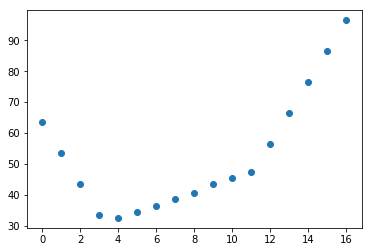

In [137]:
plt.plot(ristime_diffs_bot,'o')
plt.show()

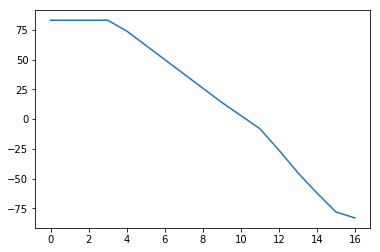

In [138]:
t50s = []
for i in range(0, 17):
    t50s.append(ristime_diffs[i]-ristime_diffs_bot[i])
    
plt.plot(t50s)
plt.show()